<hr style="border-width:2px;border-color:#84C7F7">
<center><h1> Meta-learning competition </h1></center>
<center><h2>  Few-shot learning </h2></center>
<hr style="border-width:2px;border-color:#84C7F7">

Make sure you have the **meta_dataset** and **metadl** packages installed in your kernel environment. If you ran the <code>quick_start.sh</code> script, make sure you activated the **metadl** conda environment before launching the jupyter notebook. Here is the link of the [CodaLab competition](https://competitions.codalab.org/competitions/26212?secret_key=a50a8a46-e33a-497c-9121-d56a0b576c07) where you can submit your code and check the leaderboard.


<u>**Outline**</u> : 
* **I - Data exploration** : We define the few-shot learning setup and explore how the data is formatted
* **II - Submission details** : We present how a submission should be organized
* **III - Test and submission** : We present how to test a potential submission and also how to zip your scripts to submit your code on CodaLab. 

In [1]:
import os
from collections import Counter

import gin
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from meta_dataset.data import config
from meta_dataset.data import pipeline
from meta_dataset.data import learning_spec
from meta_dataset.data import dataset_spec as dataset_spec_lib

tf.get_logger().setLevel('INFO')

def plot_episode(support_images, support_class_ids, query_images,
                 query_class_ids, size_multiplier=1, max_imgs_per_col=10,
                 max_imgs_per_row=10):
    """Plots the content of an episode. Episodes are composed of a support set 
    (training set) and a query set (test set). The different numbers of examples in
    each set will be detailled in the starting kit.
    Args:
        - support_images : tuple, (Batch_size_support, Height, Width, Channels)
        - support_class_ids : tuple, (Batch_size_support, N_class)
        - query_images : tuple, (Batch_size_query, Height, Width, Channels)
        - size_multiplier : dilate or shrink the size of displayed images
        - max_imgs_per_col : Integer, Number of images in a column
        - max_imgs_per_row : Integer, Number of images in a row
    """
    
    for name, images, class_ids in zip(('Support', 'Query'),
                                     (support_images, query_images),
                                     (support_class_ids, query_class_ids)):
        n_samples_per_class = Counter(class_ids)
        n_samples_per_class = {k: min(v, max_imgs_per_col)
                               for k, v in n_samples_per_class.items()}
        id_plot_index_map = {k: i for i, k
                             in enumerate(n_samples_per_class.keys())}
        num_classes = min(max_imgs_per_row, len(n_samples_per_class.keys()))
        max_n_sample = max(n_samples_per_class.values())
        figwidth = max_n_sample
        figheight = num_classes
        if name == 'Support':
            print('#Classes: %d' % len(n_samples_per_class.keys()))
        figsize = (figheight * size_multiplier, figwidth * size_multiplier)
        fig, axarr = plt.subplots(
            figwidth, figheight, figsize=figsize)
        fig.suptitle('%s Set' % name, size='15')
        fig.tight_layout(pad=3, w_pad=0.1, h_pad=0.1)
        reverse_id_map = {v: k for k, v in id_plot_index_map.items()}
        for i, ax in enumerate(axarr.flat):
            ax.patch.set_alpha(0)
            # Print the class ids, this is needed since, we want to set the x axis
            # even there is no picture.
            ax.set(xlabel=reverse_id_map[i % figheight], xticks=[], yticks=[])
            ax.label_outer()
        for image, class_id in zip(images, class_ids):
            # First decrement by one to find last spot for the class id.
            n_samples_per_class[class_id] -= 1
            # If class column is filled or not represented: pass.
            if (n_samples_per_class[class_id] < 0 or
              id_plot_index_map[class_id] >= max_imgs_per_row):
                continue
            # If width or height is 1, then axarr is a vector.
            if axarr.ndim == 1:
                ax = axarr[n_samples_per_class[class_id]
                           if figheight == 1 else id_plot_index_map[class_id]]
            else:
                ax = axarr[n_samples_per_class[class_id], id_plot_index_map[class_id]]
            ax.imshow(image / 2 + 0.5)
        plt.show()


def iterate_dataset(dataset, n):
    """ Iterates over an episode generator represented by dataset.
    It yields n episodes. An episode is a tuple containing images from 
    the support (train set) and query set (test set). A full episode description
    is available in the starting kit.
    """
    if not tf.executing_eagerly():
        iterator = dataset.make_one_shot_iterator()
        next_element = iterator.get_next()
        with tf.Session() as sess:
            for idx in range(n):
                yield idx, sess.run(next_element)
    else:
        for idx, episode in enumerate(dataset):
            if idx == n:
                break
            yield idx, episode

In [2]:
ls


Api.png          __pycache__/               mysubmission.zip  tutorial.ipynb
FSL_setting.png  evaluation-flow-chart.png  quick_start.sh*   zip_utils.py
README.md        logs/                      sandbox.ipynb
__init__.py      model_dir/                 scoring_output/


# I - Data exploration
 The goal of this section is to familiarize participants with the data format used in the challenge.

Few-shot learning procedures aim to produce a Learner that is able to quickly adapt to unseen tasks with a few examples. 
In the standard Machine Learning setting, we usually split the data in train/test sets, these datasets then contain **examples** assumed to be generated from the same distribution. In few-shot learning, we have the same idea but with one additional level of abstraction : we have a meta-train and meta-test split (optionnally a meta-validation split as well). Indeed, meta-train and meta-test dataset are assumed to have **classes** generated from the same **task distribution**. For instance, we consider the Omniglot dataset during the public phase of the challenge. Omniglot is composed of 1623 classes that makes it interesting for meta-learning problems. We seperate these classes in 3 splits, a meta-train, meta-validation and meta-test sets. 
* **Meta-training** : with data sampled from the meta-train pool, we could meta-train a MetaLearner, i.e. try to learn the best approach to tackle different tasks.
* **Meta-validation** : with data sampled from the meta-validation pool, we could adjust the meta-learner's hyper-parameters without worrying about any data leakage.
* **Meta-testing** : with data sampled from the meta-test pool, we evaluate the Learner produced by the meta-learning procedure to quickly adapt to new unseen tasks. In order to measure the performance of such behavior, we define what we call **episodes**. These are small tasks, i.e. with a few training examples of unseen classes.

Let's formalize some of the ideas exposed above.

## Definitions
 Previously we mentionned the possibility of generating data from a specific split pool. There are 2 different ways to generate data in this challenge. We can either generate data in the form of **episodes** or **batches**. Let's first describe these 2 methods : 

An **episode**, which represents a **task**, is described as follows : 
$$ \mathcal{T} = \{ \mathcal{D}_{train}, \mathcal{D}_{test}\}$$
where $\mathcal{D}_{train} = \{x_{i}, y_{i}\}_{i \in \mathcal{I}_{train}}$ is the training set of the task, often called **support set**. $\mathcal{D}_{test} = \{x_{i}, y_{i}\}_{i \in \mathcal{I}_{test}}$ is the test set of the task, often called **query set**. Note that $\mathcal{I}_{train}$ and $\mathcal{I}_{test}$ are indices of the train and test set examples respectively.

A **batch** is a collection of examples sampled from a split pool but **without enforcing a configuration**. For instance, let's say we want to generate data in batch mode from the meta-train pool. We can specify the batch size which is the number of examples to be sampled from the pool. We would directly sample examples from the pool without sampling **classes** as it is the case for episodes. More importantly, there would be no aforementionned $\mathcal{D}_{test}$ unlike the episodic setting. In order to better visualize the difference with the episode setting, we provide a figure below to illustrate these 2 methods.

![Challenge API](FSL_setting.png)


## The few-shot learning problem

The few-shot learning problems are often referred as N-way K-shots problem. This name refers to episodes configuration at **meta-test time**. The number of **ways** N denotes the number of classes in an episode that represents an image classification problem. The number of **shots** K denotes the number of examples per class in the **support set**. In our case, we focus on the **5-way 1-shot** setting. In other words, episodes at meta-test time represent image classification problems with exactly 5 classes, and the **support set** contains 1 labelled example per class. More formally, $|\mathcal{I}_{train} | = 5$. 
Let's summarize the different parts of the meta-learning procedure.

* At **meta-train** time : This is the part you have control on. You can choose to generate data from the meta-train split in the form of **episodes** or **batches**.
* At **meta-test** time : We always evaluate your few-shot learning algorithm using the same setting, we generate new unseen tasks from the meta-test pool in the form of episodes. Actually these episodes have a fixed configuration, the 5-way 1-shot setting. It essentially means that when you receive a new unseen task, the support set (i.e. train set) will be composed of 5 examples, 1 for each class represented. The query set (i.e. test set) is composed of multiple unlabelled examples corresponding to theses classes. We control the number of examples in the query set, and it depends on the challenge phase. For instance, for the Omniglot dataset, the episodes' query sets at meta-test time are composed of 19 examples per class (95 examples in total).

In this challenge, the episodes are generated **on the fly** from our datasets. Also, it is worth mentioning that the episodes and batches are coming from **generators**, meaning that there are virtually infinite. 
 
The number of examples in the **query set** usually depends on the number of examples for each class available in a dataset. In the public dataset (Omniglot), each class has 20 examples and we thus decide to set $|\mathcal{I}_{test}| = |N| * 19$ = 95. A visual example using the Omniglot dataset using this setting is displayed in the figure below. Note that this setting is an example, one could change the way the data is received at meta-train time. For example we could change the number of classes in an episode at meta-train time as in the prototypical networks algorithm. That is, you creates episodes containing 60 classes at meta-train time and evaluate the meta-learning algorithm performance with episodes containing 5 classes at meta-test time. 




**Note** : Make sure you have downloaded the public data under <code>omniglot/</code> directory in the root directory of this project, i.e. **../metadl**.
Let's see how it looks like in practice : 

In [3]:
from metadl.data.dataset import DataGenerator

config_episode = [28, 5, 1, 19] # [img_size, N_ways, K_shot, nbr_query_ex]
meta_train_dir = '../../omniglot/meta_train' # Path to Public data


# The DataGenerator initialization creates 2 generators as attributes :
# Meta-train data generator : meta_train_pipeline
# Meta-valid data generator : meta_valid_pipeline
data_generator = DataGenerator(path_to_records=meta_train_dir,
                                batch_config=None,
                                episode_config=config_episode,
                                valid_episode_config=config_episode,
                                pool='train',
                                mode='episode')
meta_train_generator = data_generator.meta_train_pipeline
meta_valid_generator = data_generator.meta_valid_pipeline


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


In the previous cell, we created a <code>DataGenerator</code> object. You receive data during meta-training through this object. Notice that you can specify the configuration of meta-train and meta-valid episodes, but you could switch to <code>mode='batch'</code> if you think it would improve your meta-algorithm performance. We are going to visualize data generated as **episodes** and **batches** in the next code cells. 

Episode id: 0 from source omniglot
#Classes: 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


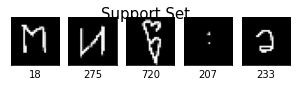

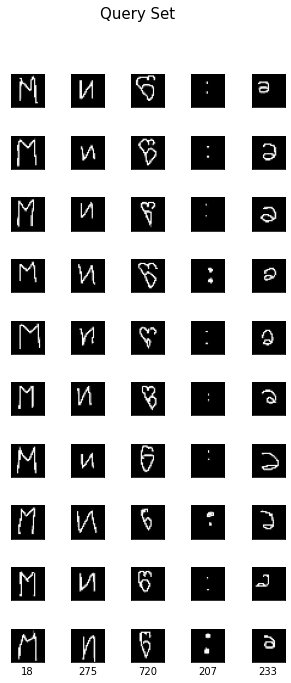

Episode id: 1 from source omniglot
#Classes: 5


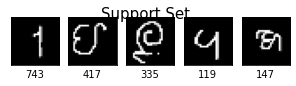

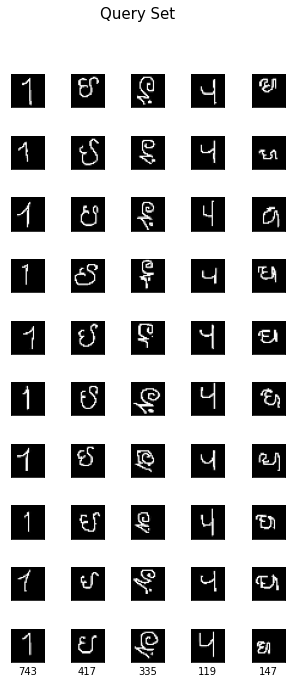

In [5]:
N_EPISODES=2

dataset_spec = dataset_spec_lib.load_dataset_spec(meta_train_dir)
all_dataset_specs = [dataset_spec]

for idx, (episode, source_id) in iterate_dataset(meta_train_generator, N_EPISODES):
    print('Episode id: %d from source %s' % (idx, all_dataset_specs[source_id].name))
    episode = [a.numpy() for a in episode]
    plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

In the figures above, you can observe the composition of an episode : A **support set** (train) and a **query set** (test). In the next cell, we present some useful caracteristics of an episode.

In [6]:
print('Length of the tuple describing an episode : {} \n'\
      .format(len(episode)))
print('#'*70)
print('\nThe episode tuple is organized the following way : \n \n ' + 
     '[Support_images, Support_labels, Support_original_labels,' + 
      'Query_images, Query_labels, Query_original_labels] \n')
print('#'*70)
print('\nThe support set images are of the following shape : {} \n'\
      .format(episode[0].shape))
print('The support set labels are : {} and their shape : {} \n'\
      .format(episode[1], episode[1].shape))

print('The support set original labels in the dataset from which' +
        ' they are sampled : {} and shape : {}\n'\
       .format(episode[2], episode[2].shape))
print('#'*70)
print('\nThe query set images are of the following shape : {} \n'\
      .format(episode[3].shape))
print('The query set labels shape is : {} \n'\
      .format(episode[4].shape))

print('The query set original labels shape in the dataset from which' +
        ' they are sampled is : {} \n'\
       .format(episode[5].shape))

Length of the tuple describing an episode : 6 

######################################################################

The episode tuple is organized the following way : 
 
 [Support_images, Support_labels, Support_original_labels,Query_images, Query_labels, Query_original_labels] 

######################################################################

The support set images are of the following shape : (5, 28, 28, 3) 

The support set labels are : [0 1 2 3 4] and their shape : (5,) 

The support set original labels in the dataset from which they are sampled : [743 417 335 119 147] and shape : (5,)

######################################################################

The query set images are of the following shape : (95, 28, 28, 3) 

The query set labels shape is : (95,) 

The query set original labels shape in the dataset from which they are sampled is : (95,) 



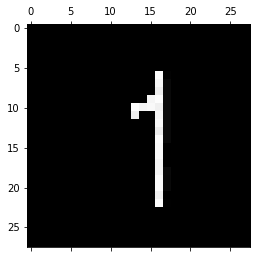

In [7]:
plt.matshow(episode[0][0])
plt.show()

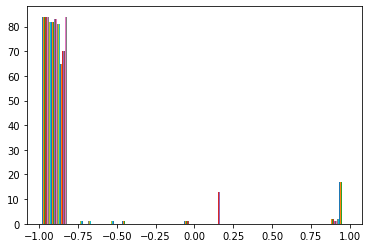

In [8]:
plt.hist(episode[0][0].reshape(28*3,28))
plt.show()

In [9]:
class sentive_neuron_helper():
    def __init__(self):
        self.init_matrix = []
        self.init_matrix.append( np.array([[1, 0, -1],[1, 0, -1],[1, 0, -1]]))
        self.init_matrix.append( np.array([[1, 1, 0],[1, 0, -1],[0, -1, -1]]))
        self.init_matrix.append( np.array([[1, 1, 1],[0, 0, 0],[-1, -1, -1]]))
        self.init_matrix.append( np.array([[0, 1, 1],[-1, 0, 1],[-1, -1, 0]]))
        
        
    def FctIterMean(self, Nb_activations, NewAct, avgValue):
        Nb_activations = int(Nb_activations)
        NewAct = float(NewAct)
        avgValue = float(avgValue)
        return ((Nb_activations - 1) / Nb_activations
                * avgValue + NewAct / Nb_activations)
    
    
    def get_x_matrix(self, size):
        size = int(size)
        if size>=2:
            output = np.array([np.arange(size),np.arange(size)])
        else:
            return np.array(np.arange(size))
        for i in range(2,size):
            output = np.append(output,[np.arange(size)],axis=0)
        return output

    
    def get_y_matrix(self, size):
        size = int(size)
        if size>=2:
            output = np.array([np.ones(size)*0,np.ones(size)*1])
        else:
            return np.array(np.arange(size))
        for i in range(2,size):
            output = np.append(output,[np.ones(size)*i],axis=0)
        return output
    
    def get_matrix_center(self, size):
        return np.floor(size/2)

    
    def get_receptive_field(self, local_neuron, current_vision):
        """
            {'center': {'x': 11, 'y': 7},
             'matrix_width': 3,
             'local_tip_1': {'x': 0, 'y': 1.0},
             'local_tip_2': {'x': 2.0, 'y': 0},
             'axes_symétrie': [0, 3]}
        """
        min_val_y = int(local_neuron["center"]["y"] - np.floor(
                                                local_neuron["matrix_width"]/2))
        max_val_y = int(local_neuron["center"]["y"] + np.ceil(
                                                local_neuron["matrix_width"]/2))
        min_val_x = int(local_neuron["center"]["x"] - np.floor(
                                                local_neuron["matrix_width"]/2))
        max_val_x = int(local_neuron["center"]["x"] + np.ceil(
                                                local_neuron["matrix_width"]/2))
        return current_vision[min_val_y:max_val_y, min_val_x:max_val_x, 0]
    

    def get_all_center_fields(self, list_neurons, current_vision):
        """
            Retourne l'image avec les centres des neurones surlignés
        """
        for sent_neuron in list_neurons:
            neuron = sent_neuron.neuron
            current_vision[neuron["center"]["y"],neuron["center"]["x"]] = 3 * current_vision[neuron["center"]["y"],neuron["center"]["x"]]
        return current_vision
    
    
    def update_coord(self, previous):
        """
            lorsqu'on augmente la taille de la matrice de +2
            Toutes les coordonnées relatives à la taille précédente doivent être modifiées grace 
            à cette fonction.
        """
        previous["x"] += 1
        previous["y"] += 1
        return previous
    
    
    def rotate_vector(self, vector, angle_rotation):
        vector["x"] = np.around(vector["x"] * np.cos(angle_rotation) - vector["y"] * np.sin(angle_rotation))
        vector["y"] = np.around(vector["x"] * np.sin(angle_rotation) + vector["y"] * np.cos(angle_rotation))
        return vector
    
    def anti_rotate_vector(self, vector, angle_rotation):
        vector["x"] = np.around(vector["x"] * np.cos(angle_rotation) + vector["y"] * np.sin(angle_rotation))
        vector["y"] = np.around(vector["y"] * np.cos(angle_rotation) - vector["x"] * np.sin(angle_rotation))
        return vector


class sentive_neuron(object):
    def __init__(self, number):
        self.number = number
        self.neuron = {
            "type": "sentive_vision_arcs",
            "mode": "croissance",
            "center":{
                "x":0,
                "y":0
            },
            "matrix_width":3,
            "local_tip_1":{
                "x":0,
                "y":0
            },
            "vector_1":{
                "x":0,
                "y":0
            },
            "local_tip_2":{
                "x":0,
                "y":0
            },
            "vector_2":{
                "x":0,
                "y":0
            },
            "axes_symétrie":[],
            "angle":-999
        }
    

In [10]:
toto = sentive_neuron_helper()

In [12]:
# meta parameters
SEUIL = 0
SEUIL_EXTRA = -0.8
MAX_IMG_SIZE = 28

# end metaparameters

nb = 0
pool_vision = []
for y in range(1,27):
    for x in range(1,27):
        if episode[0][0][y][x][0]>0:
            pool_vision.append(sentive_neuron(nb))
            pool_vision[nb].neuron["center"]["x"] = x
            pool_vision[nb].neuron["center"]["y"] = y
            nb += 1
print("nombre de neurones taille 1:",len(pool_vision))
print("*"*40,"\n")

neuron_tools = sentive_neuron_helper()

pop_list = []
for neuron_idx in range(len(pool_vision)):
    can_be_deleted = True
    # position du centre du neurone
    x = pool_vision[neuron_idx].neuron["center"]["x"]
    y = pool_vision[neuron_idx].neuron["center"]["y"]
    sub_matrix = episode[0][0][y-1:y+2, x-1:x+2, 0]
    if np.sum(sub_matrix>SEUIL)>5:
        print("suppression cause taille",neuron_idx)
        pop_list.append(neuron_idx)
        continue
    for conv_idx in range(len(neuron_tools.init_matrix)):
        # s'il n'y a pas de pixels en dehors de l'axe de symétrie, y a rien à calculer.
        if np.sum(np.multiply(sub_matrix>SEUIL, toto.init_matrix[conv_idx])>SEUIL)==0:
            continue
        # si c'est symétrique par rapport à l'axe choisi, alors ce calcul donne zéro
        if np.sum(np.multiply(sub_matrix>SEUIL, neuron_tools.init_matrix[conv_idx])) == 0:
            # il ne doit donc pas être supprimé
            can_be_deleted = False
            # calcul de l'axe de symétrie :
            pool_vision[neuron_idx].neuron["axes_symétrie"].append(conv_idx)
                
    if can_be_deleted is True:
        print("suppression cause asymétrie",neuron_idx)
        print(sub_matrix>SEUIL)
        pop_list.append(neuron_idx)
    else:
        # calcul du barycentre
        sub_mask = neuron_tools.init_matrix[int(np.around(pool_vision[neuron_idx].neuron["axes_symétrie"][0]))]
        sub_result = np.multiply(sub_mask, sub_matrix>SEUIL)
        # d'un côté de l'axe (valeurs positives)
        tmp_coord = np.trim_zeros(np.multiply(sub_result>0,neuron_tools.get_y_matrix(3)).ravel())
        if len(tmp_coord)>0:
            pool_vision[neuron_idx].neuron["local_tip_1"]["y"] = np.mean(tmp_coord)
        tmp_coord = np.trim_zeros(np.multiply(sub_result>0,neuron_tools.get_x_matrix(3)).ravel())
        if len(tmp_coord)>0:  
            pool_vision[neuron_idx].neuron["local_tip_1"]["x"] = np.mean(tmp_coord)
    
        # calcul des vecteurs directeurs
        pool_vision[neuron_idx].neuron["vector_1"]["y"] = pool_vision[neuron_idx].neuron["local_tip_1"]["y"] - neuron_tools.get_matrix_center(pool_vision[neuron_idx].neuron["matrix_width"])
        pool_vision[neuron_idx].neuron["vector_1"]["x"] = pool_vision[neuron_idx].neuron["local_tip_1"]["x"] - neuron_tools.get_matrix_center(pool_vision[neuron_idx].neuron["matrix_width"])
        
        # les pixels de l'autre côté de l'axe les valeurs sont négatives
        tmp_coord = np.trim_zeros(np.multiply(sub_result<0,neuron_tools.get_y_matrix(3)).ravel())
        if len(tmp_coord)>0: 
            pool_vision[neuron_idx].neuron["local_tip_2"]["y"] = np.mean(tmp_coord)
        tmp_coord = np.trim_zeros(np.multiply(sub_result<0,neuron_tools.get_x_matrix(3)).ravel())
        if len(tmp_coord)>0:
            pool_vision[neuron_idx].neuron["local_tip_2"]["x"] = np.mean(tmp_coord)
            
        # calcul des vecteurs directeurs
        pool_vision[neuron_idx].neuron["vector_2"]["y"] = pool_vision[neuron_idx].neuron["local_tip_2"]["y"] - neuron_tools.get_matrix_center(pool_vision[neuron_idx].neuron["matrix_width"])
        pool_vision[neuron_idx].neuron["vector_2"]["x"] = pool_vision[neuron_idx].neuron["local_tip_2"]["x"] - neuron_tools.get_matrix_center(pool_vision[neuron_idx].neuron["matrix_width"])
        
        # calcul de l'angle pour la rotation
        np_c_1 = np.array([pool_vision[neuron_idx].neuron["vector_1"]["x"], pool_vision[neuron_idx].neuron["vector_1"]["y"]])
        np_c_2 = np.array([pool_vision[neuron_idx].neuron["vector_2"]["x"], pool_vision[neuron_idx].neuron["vector_2"]["y"]])
        
        pool_vision[neuron_idx].neuron["angle"] = np.pi - np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

print("neurones à supprimer:",pop_list)
for neuron_idx in pop_list[::-1]:
    pool_vision.pop(neuron_idx)
    
print("\nnombre de neurones taille 3:",len(pool_vision))
print("*"*40)

for neuron_idx in range(len(pool_vision)):
    if pool_vision[neuron_idx].neuron["mode"]=="croissance":       
        # essaye d'augmenter la taille
        # vérifie que la taille ne sort pas du cadre :
        tmp_half = np.floor(pool_vision[neuron_idx].neuron["matrix_width"]/2)
        t1 = (pool_vision[neuron_idx].neuron["center"]["x"]-1- tmp_half)>=0
        t2 = (pool_vision[neuron_idx].neuron["center"]["x"]+1+tmp_half)<MAX_IMG_SIZE
        t3 = (pool_vision[neuron_idx].neuron["center"]["y"]-1-tmp_half)>=0
        t4 = (pool_vision[neuron_idx].neuron["center"]["y"]-1-tmp_half)<MAX_IMG_SIZE
        if t1 and t2 and t3 and t4:
            pool_vision[neuron_idx].neuron["matrix_width"] += 2
        else:
            # si le moteur n'y arrive pas, alors change le mode 
            pool_vision[neuron_idx].neuron["mode"] = "edge"
            continue
        # Je mets en à jour la position des extrémités dans les coordonnées de taille supérieure
        neuron_tools.update_coord(pool_vision[neuron_idx].neuron['local_tip_1'])    
        neuron_tools.update_coord(pool_vision[neuron_idx].neuron['local_tip_2'])
        # J'applique la rotation sur les vecteurs.
        neuron_tools.anti_rotate_vector(pool_vision[neuron_idx].neuron["vector_2"],
                                    pool_vision[neuron_idx].neuron["angle"])
        neuron_tools.rotate_vector(pool_vision[neuron_idx].neuron["vector_1"],
                                    pool_vision[neuron_idx].neuron["angle"])
        # Détermine les nouvelles extrémités suspectées
        
        suspect_1 = pool_vision[neuron_idx].neuron['local_tip_1']
        
        

nombre de neurones taille 1: 35
**************************************** 

suppression cause taille 2
suppression cause taille 3
suppression cause taille 4
suppression cause taille 5
suppression cause taille 6
suppression cause taille 7
suppression cause taille 8
suppression cause taille 11
suppression cause taille 12
suppression cause taille 13
suppression cause asymétrie 14
[[False  True  True]
 [False  True False]
 [False False False]]
suppression cause taille 15
suppression cause taille 16
suppression cause taille 17
suppression cause taille 18
suppression cause taille 19
suppression cause taille 20
suppression cause asymétrie 21
[[False  True  True]
 [False  True  True]
 [False  True False]]
suppression cause asymétrie 22
[[ True  True False]
 [ True  True False]
 [ True False False]]
suppression cause asymétrie 26
[[False  True False]
 [False  True  True]
 [False  True  True]]
suppression cause asymétrie 27
[[ True False False]
 [ True  True False]
 [ True  True False]]
suppressi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


In [630]:
np.array([pool_vision[neuron_idx].neuron["vector_2"]["x"], pool_vision[neuron_idx].neuron["vector_2"]["y"]])

array([0., 0.])

In [13]:
pool_vision[neuron_idx].neuron

{'type': 'sentive_vision_arcs',
 'mode': 'croissance',
 'center': {'x': 16, 'y': 22},
 'matrix_width': 5,
 'local_tip_1': {'x': 2.0, 'y': 1},
 'vector_1': {'x': 1.0, 'y': 1.0},
 'local_tip_2': {'x': 3.0, 'y': 2.0},
 'vector_2': {'x': 0.0, 'y': 0.0},
 'axes_symétrie': [1],
 'angle': 1.5707963267948966}

In [15]:
def show_all_fields(int_id=0):
    all_fields = toto.get_all_center_fields(pool_vision,episode[0][int_id][:,:,0])
    plt.matshow(all_fields)

In [16]:
def reset_episode(int_id=0):
    episode[0][int_id][:,:,0]=episode[0][int_id][:,:,1]

In [17]:
def show_receptive_field(neuron_idx,int_id=0):
    # Visualiser le champs récepteur du neurone
    current_neuron = pool_vision[neuron_idx].neuron
    sub_matrix = toto.get_receptive_field(current_neuron, episode[0][int_id])
    print(current_neuron)
    plt.matshow(sub_matrix)

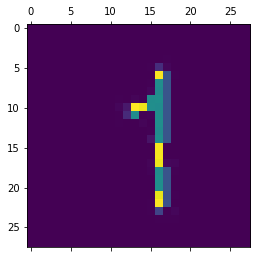

In [18]:
show_all_fields()

In [19]:
reset_episode()

{'type': 'sentive_vision_arcs', 'mode': 'croissance', 'center': {'x': 13, 'y': 10}, 'matrix_width': 5, 'local_tip_1': {'x': 3.0, 'y': 2.0}, 'vector_1': {'x': 0.0, 'y': 0.0}, 'local_tip_2': {'x': 2.0, 'y': 3.0}, 'vector_2': {'x': 1.0, 'y': -1.0}, 'axes_symétrie': [3], 'angle': 1.5707963267948966}


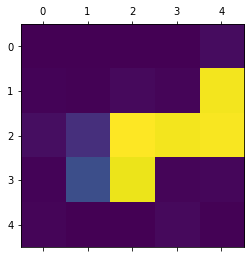

In [20]:
show_receptive_field(2)

In [21]:
pool_vision[1].neuron

{'type': 'sentive_vision_arcs',
 'mode': 'croissance',
 'center': {'x': 17, 'y': 6},
 'matrix_width': 5,
 'local_tip_1': {'x': 1, 'y': 2.0},
 'vector_1': {'x': -0.0, 'y': 0.0},
 'local_tip_2': {'x': 2.0, 'y': 3.0},
 'vector_2': {'x': 1.0, 'y': -1.0},
 'axes_symétrie': [1],
 'angle': 1.5707963267948966}

In [394]:
sub_mask = toto.init_matrix[int(np.around(pool_vision[2].neuron["axe_symétrie"]))]

In [269]:
sub_result = np.multiply(sub_mask, sub_matrix>0)

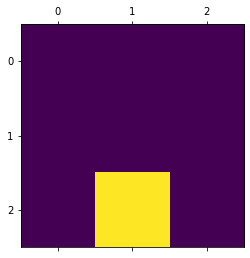

In [273]:
plt.matshow(sub_result<0)

In [383]:
np.mean(np.trim_zeros(np.multiply(sub_result<0,toto.get_y_matrix(3)).ravel()))

2.0

In [370]:
np.multiply(sub_result<0,toto.get_x_matrix(3))

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 0]])

In [282]:
np.array([np.arange(3),np.arange(3),np.arange(3)])

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [285]:
np.array([np.ones(3)*0,np.ones(3)*1,np.ones(3)*2])

array([[0., 0., 0.],
       [1., 1., 1.],
       [2., 2., 2.]])

In [324]:
A = np.array([])
print(A)

[]


In [336]:
A = np.array([np.ones(3)*0,np.ones(3)*1])
print(A)

[[0. 0. 0.]
 [1. 1. 1.]]


In [338]:
A = np.append(A,[np.ones(3)*2],axis=0)
print(A)

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]


Now let's take a look at the **batch** mode. 
Let's define the batch configuration as \[28, 30\] indicating that we'd like to receive data from the meta-train split in batches of 30 images of shape \[28,28,3\]. 

Batch images shape : (30, 28, 28, 3)
Batch labels shape : (30,)


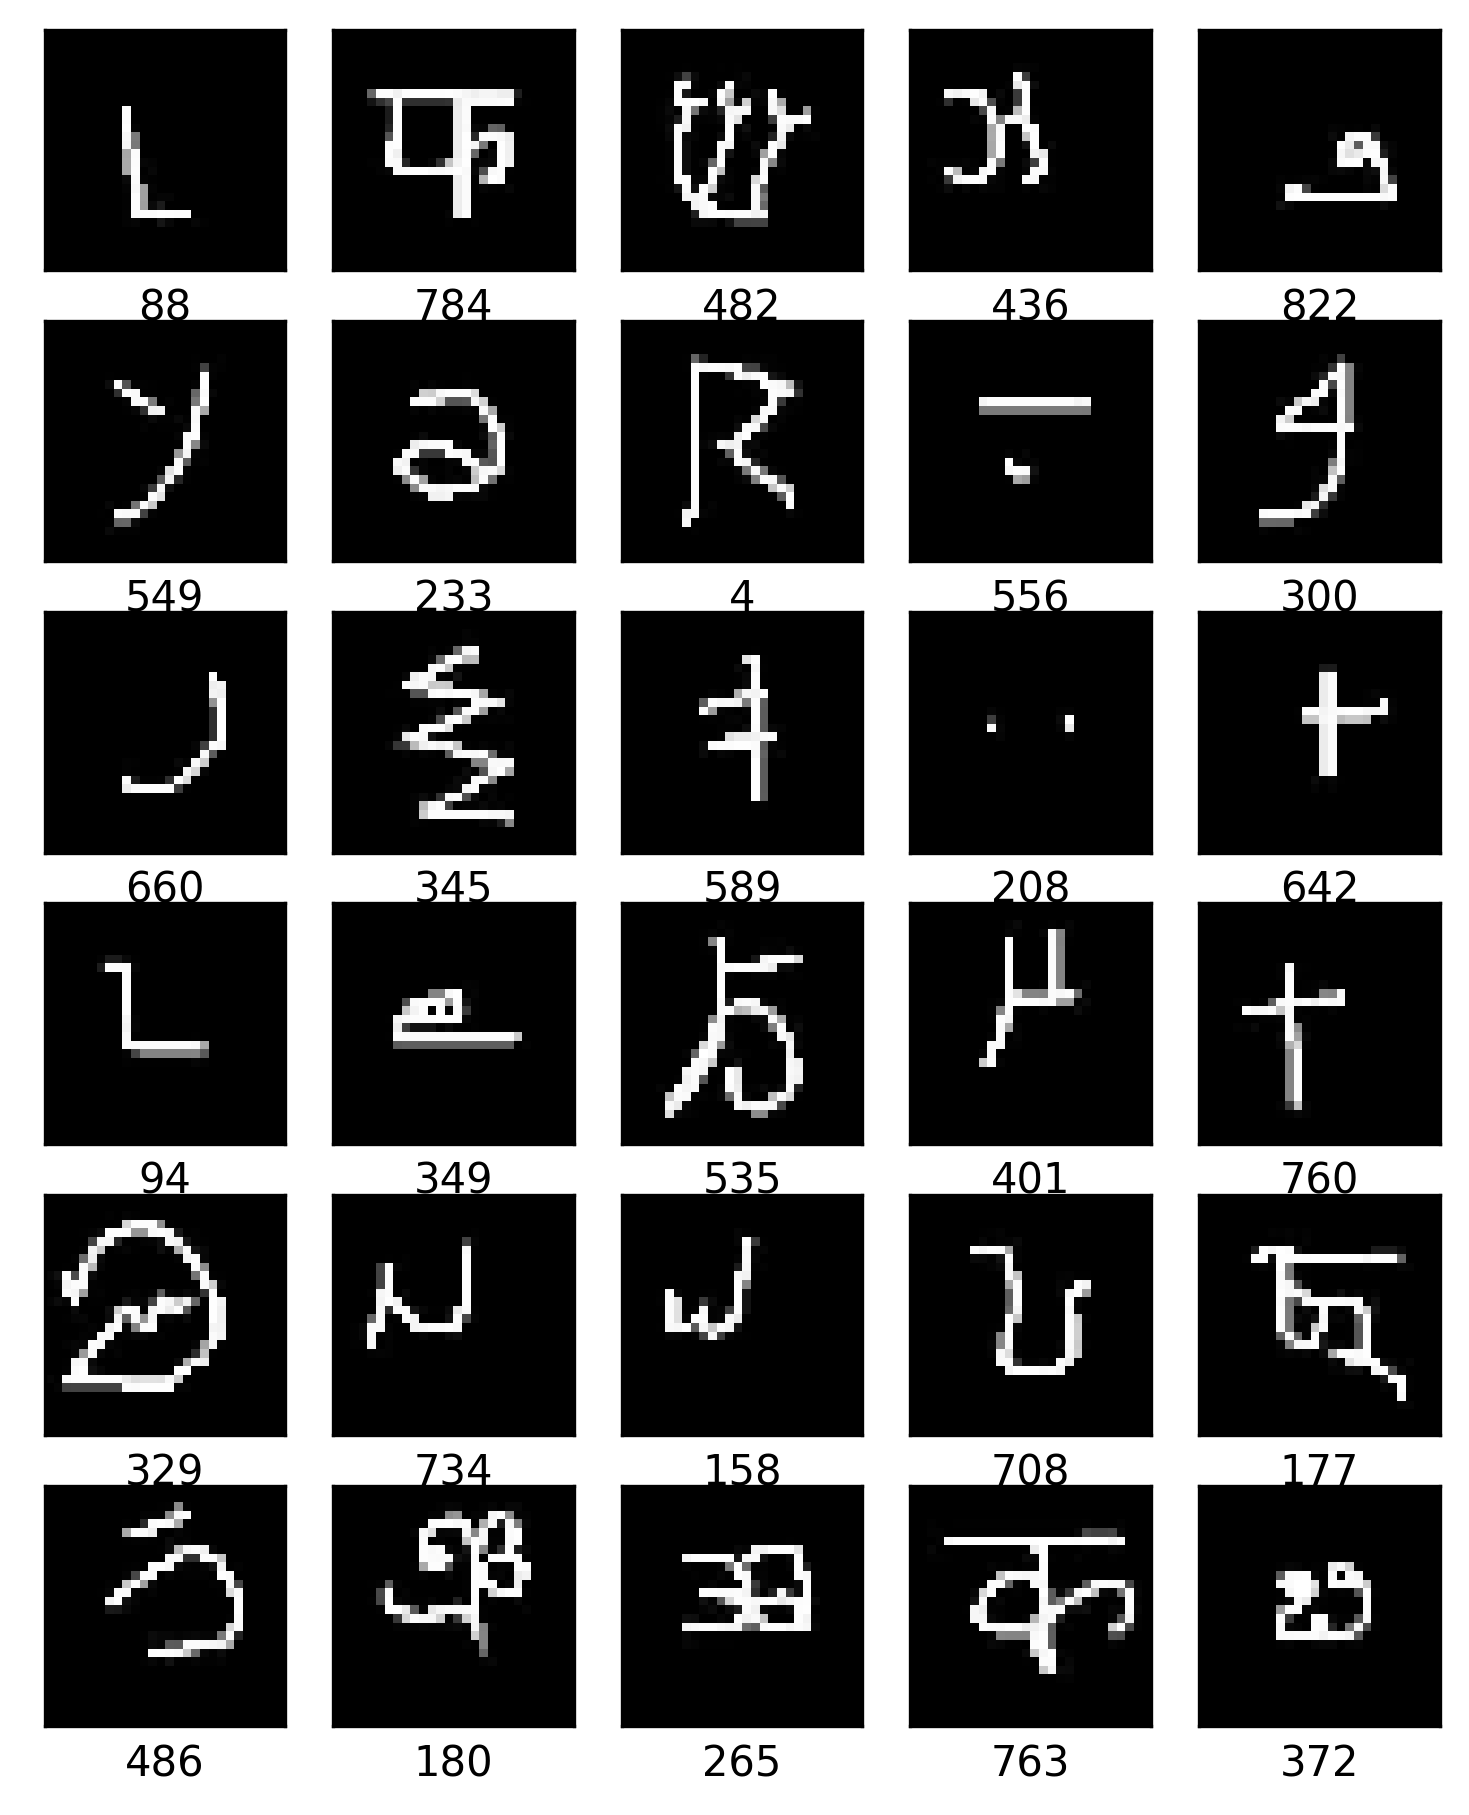

In [7]:
# The DataGenerator initialization creates 2 generators as attributes :
# Meta-train data generator : meta_train_pipeline
# Meta-valid data generator : meta_valid_pipeline
batch_data_generator = DataGenerator(path_to_records=meta_train_dir,
                                    batch_config=[28, 30],
                                    episode_config=None,
                                    valid_episode_config=[28,5,1,19],
                                    pool='train',
                                    mode='batch')

meta_train_generator = batch_data_generator.meta_train_pipeline
meta_valid_generator = batch_data_generator.meta_valid_pipeline

meta_train_iterator = meta_train_generator.__iter__()
((images, labels), _) = next(meta_train_iterator)
print(f'Batch images shape : {images.shape}')
print(f'Batch labels shape : {labels.shape}')

def plot_batch(images, labels, size_multiplier=1):
    """ Plot the images in a batch. Notice that labels,
    corresponds to images original class id_s.
    Args:
        images: tf.Tensor, shape 
                (batch_size, image_size, image_size, 3)
        labels: tf.Tensor, shape (batch_size,)
        size_multiplier: Float, defines how big images will
            be displayed.
    """
    num_examples = len(labels)
    figwidth = np.ceil(np.sqrt(num_examples)).astype('int32')
    figheight = num_examples // figwidth
    figsize = (figwidth * size_multiplier, (figheight + 2.5) * size_multiplier)
    _, axarr = plt.subplots(figwidth, figheight, dpi=300, figsize=figsize)

    for i, ax in enumerate(axarr.transpose().ravel()):
        # Images are between -1 and 1.
        ax.imshow(images[i] / 2 + 0.5)
        ax.set(xlabel=str(labels[i].numpy()), xticks=[], yticks=[])
    
    plt.show()

plot_batch(images, labels)

For the challenge, you don't need to create your generators, you will receive a DataGenerator object (thus already initialized). The way you receive the DataGenerator object will be described in the next section. The default setting is the episodic setting 5-way 1-shot for every meta-split. However, if you do think you could achieve better performance with your own meta-training setting, you can specify it. In order to specify your own setting, you need to write down your settings in a gin file named **config.gin** and put it in your submission folder before zipping it. We will go over the structure of submission folder in the next sections. Here is an example of a config file for the prototypical networks algorithms : 

**Content of a <code>config.gin</code> file**:
```bash
DataGenerator.batch_config = None
DataGenerator.episode_config = [ 28, 60, 1, 5 ]
DataGenerator.valid_episode_config = [ 28, 5, 1, 19 ]
DataGenerator.pool = 'train'
DataGenerator.mode = 'episode'
```
First, notice the configuration of episodes coming from the meta-train split, described by **episode_config**. The first value denotes the image size of the received images, here we kept the original value 28. Then you can specify the number of classes in your episodes, here it is set to 60! Then you specify the number of shots **K**, here 1. And finally you can specify the number of query examples per class, here 5. In this example, the meta-validation episodes description, **valid_episode_config**, is set to <code>[28, 5, 1, 19]</code> to match the episode configuration at meta-test time.


For clarity here are the configuration descriptions : 

<code>episode_config = [img_size, num_ways, num_shots_per_class, num_query_per_class]</code>

<code>batch_config = [img_size, batch_size]</code>

---

**Section summary** :

* You can choose to generate data from the meta-train split in the form of episodes or batches. Default configurations are episodic but you can change it via a **config.gin** file that you put in your folder submission.
* You can choose to have access to episodes coming from the meta-validation split to match the evaluation at meta-test time. However, we do not allow you to generate data from the meta-validation split in batch mode.

# II - Submission details
In this section, we will review the structure of a valid submission. We will see that the data we receive for the few-shot learning algorithm follows the aforementioned structure.



The participants would have to submit a zip file containing one or several files. The crucial file to add is <code>model.py</code>. It contains the meta-learning algorithm logic. This file **has** to follow the specific API that we defined for the challenge described in the following figure : 

![Challenge API](Api.png)

The 3 classes with their associated methods that need to be overriden are the following :
* **MetaLearner** : The meta-learner contains the meta-algorithm logic. The <code>meta_fit(data_generator)</code> method has to be overriden with your own meta-learning algorithm. It receives a DataGenerator object initialized with default setting or your **config.gin** file.

* **Learner** : It encapsulates the logic to learn from a new unseen task. Several methods need to be overriden : 
 * <code>fit(D_train)</code>: Takes a support (train) set as an argument and fit the learner according to this dataset.
 * <code>save()</code> : You need to implement a way to save your model in a pre-defined directory. 
 * <code>load()</code> : You need to implement a way to load your model from the file you created in <code>save()</code>.
* **Predictor** : The predictor contains the logic of your model to make predictions once the learner is fitted. The <code>predict(D_test)</code> encapsulates this step and takes a query (test) set as an argument, i.e. unlabelled examples.

## Walkthrough a submission example

In this sub-section, we present how your code submission folder should look like before zipping it.  

**Example of a submission directory**
```
proto
|   metadata  (Mandatory)
│   model.py  (Mandatory)
│   model.gin (Optional but has to have this name)
|   config.gin (Optional but has to have this name)
│   helper.py (Optional) 
│   utils.py  (Optional)
│   ...
```
<code>model.py</code> and <code>metadata</code> are the crucial files to be added. The former contains your few-shot learning algorithm and the latter is just a file for the competition server to work properly, you simply add it to your folder without worrying about it (you can find this file in any given baseline's folder). Other files could be added and it us up to you to organize your code as you'd like.


## Defining the classes
We go through a dummy example to understand how to create a model. In the code cell below, you can find the **zero** baseline. There are 2 important remarks :
* First, it is mandatory to **write a file** in the <code>model_dir</code> given as an argument in the <code>save()</code> method. It could be a any file, some metadata that you gathered and/or your serialized neural network, but you need to include one.
* Then, one can notice that the shape of the tensor returned by the <code>predict</code> method is (95,5). Indeed, The number of query examples is set to 95 for the episodes generated from the **meta-test** dataset, in the **Omniglot** dataset (i.e. the public dataset). Make sure your own predictions match the shape of the corresponding challenge phase. You can check the outputs shape in the CodaLab competition website. 

**Note** : You can always test your algorithm with <code>run.py</code> to verify everything is working properly. We explain how to run the script in the next section.

In [8]:
from metadl.api.api import MetaLearner, Learner, Predictor

class MyMetaLearner(MetaLearner):

    def __init__(self):
        super().__init__()

    def meta_fit(self, meta_dataset_generator) -> Learner:
        """
        Args:
            meta_dataset_generator : a DataGenerator object. We can access 
                the meta-train and meta-validation data via its attributes.
                Refer to the metadl/data/dataset.py for more details.
        
        Returns:
            MyLearner object : a Learner that stores the meta-learner's 
                learning object. (e.g. a neural network trained on meta-train
                episodes)
        """
        return MyLearner()

class MyLearner(Learner):

    def __init__(self):
        super().__init__()

    def fit(self, dataset_train) -> Predictor:
        """
        Args: 
            dataset_train : a tf.data.Dataset object. It is an iterator over 
                the support examples.
        Returns:
            ModelPredictor : a Predictor.
        """
        return MyPredictor()

    def save(self, model_dir):
        """ Saves the learning object associated to the Learner. It could be 
        a neural network for example. 

        Note : It is mandatory to write a file in model_dir. Otherwise, your 
        code won't be available in the scoring process (and thus it won't be 
        a valid submission).
        """
        if(os.path.isdir(model_dir) != True):
            raise ValueError(('The model directory provided is invalid. Please'
                + ' check that its path is valid.'))
        
        # Save a file for the code submission to work correctly.
        with open(os.path.join(model_dir,'dummy_sample.csv'), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=' ',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['Dummy example'])
            
    def load(self, model_dir):
        """ Loads the learning object associated to the Learner. It should 
        match the way you saved this object in save().
        """
        if(os.path.isdir(model_dir) != True):
            raise ValueError(('The model directory provided is invalid. Please'
                + ' check that its path is valid.'))
        
    
class MyPredictor(Predictor):

    def __init__(self):
        super().__init__()

    def predict(self, dataset_test):
        """ Predicts the label of the examples in the query set which is the 
        dataset_test in this case. The prototypes are already computed by
        the Learner.

        Args:
            dataset_test : a tf.data.Dataset object. An iterator over the 
                unlabelled query examples.
        Returns: 
            preds : tensors, shape (num_examples, N_ways). We are using the 
                Sparse Categorical Accuracy to evaluate the predictions. Valid 
                tensors can take 2 different forms described below.

        Case 1 : The i-th prediction row contains the i-th example logits.
        Case 2 : The i-th prediction row contains the i-th example 
                probabilities.

        Since in both cases the SparseCategoricalAccuracy behaves the same way,
        i.e. taking the argmax of the row inputs, both forms are valid.
        Note : In the challenge N_ways = 5 at meta-test time.
        """
        # mimick the softmax outputs
        dummy_pred = tf.constant([[1.0, 0, 0, 0 ,0]], dtype=tf.float32)
        dummy_pred = tf.broadcast_to(dummy_pred, (95, 5))
        return dummy_pred


You can refer to the <code>metadl/baselines/</code> folder if you want to see submission examples. Here are the algorithms provided : 
* The **dummy zero** baseline  
* The **Prototypical Networks** based on  [J. Snell et al. - Prototypical Networks for Few-shot Learning (2017)](https://arxiv.org/pdf/1703.05175)
* The **fo-MAML** algorithm based on [C. Finn et al. - Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks (2017)](https://arxiv.org/pdf/1703.03400)

# III - Test and Submission

Here we present the <code>run.py</code> script. It is meant to mimick what is happenning on the CodaLab platform, i.e. the competition server. Let's say you worked on an algorithm and you are ready to test it before submitting it. More specifically, it will create your MetaLearner object, run the meta-fit method and evaluate your meta-algorithm on test episodes generated from the meta-test split. You can run the script command with the following arguments :
* <code>meta_dataset_dir</code> : The path which contains the **2 meta-datasets**, the meta-train dataset and the meta-test dataset. The <code>quick_start.sh</code> script that you executed or the Docker image, downloaded the public dataset : Omniglot. 
* <code>code_dir</code> : The path which contains your **algorithm's code** following the format we previously defined. 


In [9]:
!python -m metadl.core.run --meta_dataset_dir=../../omniglot --code_dir=../baselines/sentive_ai

2021-08-26 12:36:10.634182: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I0826 12:36:13.532788 140647650514752 run.py:63] Cleaning existing output directory of last run: model_dir/
I0826 12:36:13.571436 140647650514752 run.py:63] Cleaning existing output directory of last run: scoring_output/
2021-08-26 12:36:14.066029: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
sh: 1: nvidia-smi: not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
2021-08-26 12:36:18.576592: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuil

2021-08-26 12:36:49.016468: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2021-08-26 12:36:49.017291: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c1dc20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-26 12:36:49.017445: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp2ztl4w58.py, line 52)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
W0826 12:36:56.618797 140121029621568 ag_logging.py:146] AutoGraph could not transform <bound method PythonHandler.emit of <PythonHandler <stderr> (NOTSET)>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to

## Prepare a ZIP file ready for submission
Here we present how to zip your code to submit it on the CodaLab platform. As an example, we zip the folder <code>metadl/baselines/zero/</code> which corresponds to the dummy baseline which was introduced in the previous section.

In [10]:
from zip_utils import zipdir

model_dir = '../baselines/zero/'
submission_filename = 'mysubmission.zip'
zipdir(submission_filename, model_dir)
print('Submit this file :' + submission_filename)

Submit this file :mysubmission.zip


## Summary 
For clarity, we summarize the steps that you should be aware of while making a submission : 
* Follow the **MetaLearner**/**Learner**/**Predictor** API to encapsulate your few-shot learning algorithm. Please make sure you name your subclasses as **MyMetaLearner**, **MyLearner** and **MyPredictor** respectively.
* Make sure you <u>save</u> at least a file in the given <code>model_dir</code> path. If this is a trained neural network, you need to serialize it in the <code>save()</code> method, and provide code to deserialize it in the <code>load()</code> method. Examples are provided in <code>metadl/baselines/</code>.
* In your algorithm folder, make sure you have <code>model.py</code> and <code>metadata</code> with these **exact** names. If you do use gin files, be sure to use the corresponding names as in the baselines, i.e. **model.gin** for your own model parameters and **config.gin** for the data generation configuration (batch vs episodes).

--- 

## Next steps
Now you know all the steps required to create a valid code submission.

Good luck !